In [110]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [111]:
import pandas as pd
import numpy as np
import itertools
import mplfinance as mpf
import re
import math
from math import floor
import sys
import matplotlib.pyplot as plt
import os
from dain import Adaptive_Normalizer_Layer

import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanSquaredError
from tensorflow.keras import layers
from tensorflow.keras.layers import *#Reshape, LSTM, Dense, Bidirectional, GRU, Dropout, Input, Embedding, MultiHeadAttention, LayerNormalization, Conv1D, GlobalMaxPooling1D
from fit_one_cycle import OneCycleScheduler
from lr_finder import LRFinder

from sklearn.preprocessing import MinMaxScaler


df = pd.read_parquet('df_LSTM.parquet').reset_index().reset_index().set_index('datetime', drop=True)#['2003-01-01 03:27:00':]
df_dropped = df.drop(columns=['index'])
#df.datetime = pd.to_datetime(df.datetime)
#df = df.set_index('datetime', drop=True)

In [144]:
# Define the data generator function
def data_generator(data, window_size, batch_size, indices, test=False, shap=False):
    while True:
        batch_data = []
        batch_targets = []
        open_prices = []
        dates = []
        for index in indices:
            window_end = index
            window_start = window_end - window_size
            
            open_price = data.iloc[window_end].open_es
            
            # Extract the input sequence for the window
            input_sequence = data[window_start : window_end + 150].copy(deep=True)
            
            for col in price_cols_to_normalize:
                input_sequence.loc[:, col] = np.log(input_sequence[col] / open_price).replace(-np.inf, 0)

            # Extract the target high and low values
            target_high = input_sequence[-150: ].high_es.max()
            target_low = input_sequence[-150:].low_es.min()

            # Add the input sequence and targets to the batch
            batch_data.append(input_sequence[:-150])
            batch_targets.append([target_high, target_low])
            open_prices.append(open_price)
            dates.append(data.iloc[window_end].name.date().strftime("%Y-%m-%d"))

            #print([target_high, target_low], index)
            if len(batch_data) == batch_size:
                
                # Convert to np.array
                batch_data = np.array(batch_data)
                batch_targets = np.array(batch_targets)
                
                # Normalize
                scaler = MinMaxScaler()
                batch_data = scaler.fit_transform(batch_data.reshape(-1, batch_data.shape[-1])).reshape(batch_size, window_size, num_features)
                
                if test:
                    yield np.asarray(batch_data).astype('float32'), np.asarray(batch_targets).astype('float32'), np.asarray(open_prices), np.asarray(dates)
                elif shap:
                    yield tf.convert_to_tensor(np.asarray(batch_data).astype('float32'), np.asarray(batch_targets).astype('float32'))
                else:
                    yield np.asarray(batch_data).astype('float32'), np.asarray(batch_targets).astype('float32')
                batch_data = []
                batch_targets = []
                open_prices = []
                dates = []
                
        # Yield the remaining batch if it doesn't equal the batch size
        if batch_data:
            if test:
                yield np.asarray(batch_data).astype('float32'), np.asarray(batch_targets).astype('float32'), np.asarray(open_prices), np.asarray(dates)
            elif shap:
                    yield tf.convert_to_tensor(np.asarray(batch_data).astype('float32'), np.asarray(batch_targets).astype('float32'))
            else:
                yield np.array(batch_data).astype('float32'), np.array(batch_targets).astype('float32')

# Set the window size and batch size
window_size = 720 #minutes in 7 days
batch_size = 32
num_features = df_dropped.shape[1]

# Set the split ratios
train_ratio = 0.8
val_ratio = 0.1

# set random seed for the shuffle function
np.random.seed(42)

# Get the indices for training, validation, and testing splits
indices = df.loc[(df.index.hour == 9) & (df.index.minute == 30) & (df.index.dayofweek < 5)]['index'].to_numpy()
indices = indices[indices > window_size] # Filter the indices to exclude those with insufficient historical data
np.random.shuffle(indices)
train_size = int(len(indices) * train_ratio)
val_size = int(len(indices) * val_ratio)
train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

#get the mean and std for normalization
price_cols_to_normalize = df_dropped.columns[(df_dropped>1).any()]

# Create the data generators for training, validation, and testing
train_generator = data_generator(df_dropped, window_size, batch_size, train_indices)
val_generator = data_generator(df_dropped, window_size, batch_size, val_indices)
test_generator = data_generator(df_dropped, window_size, batch_size, test_indices)

# Calculate the number of steps per epoch for training and validation
train_steps_per_epoch = len(train_indices) // batch_size
val_steps = len(val_indices) // batch_size

In [113]:
# x, y = next(train_generator)
# input_dim = window_size
# inputs = tf.convert_to_tensor(x)
# gate_initializer =  tf.keras.initializers.GlorotNormal()
# bias_initializer = tf.keras.initializers.RandomNormal()
# initializer = tf.keras.initializers.Identity()
# eps = 1e-8
# linear_1 = tf.keras.layers.Dense(input_dim, kernel_initializer=initializer, use_bias=False)
# linear_2 = tf.keras.layers.Dense(input_dim, kernel_initializer=initializer, use_bias=False)

# avg = tf.keras.backend.mean(inputs, 1)
# adaptive_avg = linear_1(avg)
# adaptive_avg = tf.keras.backend.reshape(adaptive_avg, (inputs.shape[0], 1, inputs.shape[2]))
# x = inputs - adaptive_avg

# std = tf.keras.backend.mean(x ** 2, 2)
# std = tf.keras.backend.sqrt(std + eps)
# adaptive_std = linear_2(std)
# adaptive_std = tf.where(tf.math.less_equal(adaptive_std, eps), 1, adaptive_std)
# adaptive_std = tf.keras.backend.reshape(adaptive_std, (inputs.shape[0], 1, inputs.shape[2]))

In [120]:
# Define the Transformer model

# Set the window size and number of features

# Define the input layer
inputs = Input(shape=(window_size, num_features), batch_size=batch_size)
#x = Adaptive_Normalizer_Layer(input_dim=window_size)(inputs)
x = tf.keras.layers.BatchNormalization()(inputs)

# Add LSTM layers
x = LSTM(32, return_sequences=True)(x)
x = Dropout(0.5)(x)
x = LSTM(32, return_sequences=True)(x)
x = Dropout(0.5)(x)
#x = BatchNormalization()(x)

# Add transformer layers
x = tf.keras.layers.MultiHeadAttention(num_heads=4, key_dim=64)(x, x, x)
#x = Dropout(0.5)(x)
x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
x = TimeDistributed(Dense(32, activation='relu'))(x)
x = Dropout(0.5)(x)


# Define the output layer
output1 = TimeDistributed(Dense(1), name='output1')(x)
output2 = TimeDistributed(Dense(1), name='output2')(x)
output1 = GlobalAveragePooling1D()(output1)
output2 = GlobalAveragePooling1D()(output2)
outputs = [output1, output2]
output = Concatenate()([output1, output2])
output = Dense(2)(output)

# Define the model with two outputs
model = Model(inputs=inputs, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'], run_eagerly=False)

In [121]:
model.summary()

Model: "model_22"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(32, 720, 72)]      0           []                               
                                                                                                  
 batch_normalization_17 (BatchN  (32, 720, 72)       288         ['input_23[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 lstm_44 (LSTM)                 (32, 720, 32)        13440       ['batch_normalization_17[0][0]'] 
                                                                                                  
 dropout_68 (Dropout)           (32, 720, 32)        0           ['lstm_44[0][0]']         

Epoch 1/30
140/140 [==============================] - 115s 601ms/step - loss: 0.0351 - mae: 0.0687 - val_loss: 2.4488e-04 - val_mae: 0.0124
Epoch 2/30
140/140 [==============================] - 82s 587ms/step - loss: 1.7249e-04 - mae: 0.0101 - val_loss: 8.3252e-05 - val_mae: 0.0068
Epoch 3/30
140/140 [==============================] - 81s 579ms/step - loss: 1.0059e-04 - mae: 0.0077 - val_loss: 1.6247e-04 - val_mae: 0.0102
Epoch 4/30
140/140 [==============================] - 83s 590ms/step - loss: 8.7490e-05 - mae: 0.0072 - val_loss: 5.8538e-05 - val_mae: 0.0056
Epoch 5/30
140/140 [==============================] - 80s 571ms/step - loss: 6.7425e-05 - mae: 0.0063 - val_loss: 4.3040e-05 - val_mae: 0.0045
Epoch 6/30
140/140 [==============================] - 80s 570ms/step - loss: 5.1878e-05 - mae: 0.0053 - val_loss: 6.0033e-05 - val_mae: 0.0054
Epoch 7/30
140/140 [==============================] - 80s 570ms/step - loss: 4.4322e-05 - mae: 0.0049 - val_loss: 4.3270e-05 - val_mae: 0.0048
Ep

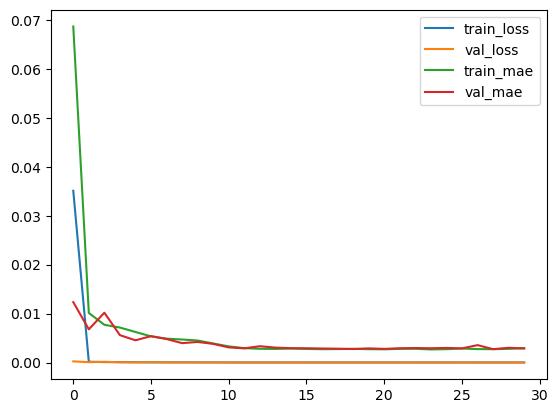

In [122]:
epochs = 30
lr = 1e-2
lr_schedule = OneCycleScheduler(lr, train_steps_per_epoch)

history = model.fit(train_generator, steps_per_epoch=train_steps_per_epoch, epochs=epochs,
          validation_data=val_generator, validation_steps=val_steps, callbacks=[lr_schedule])

# Plot the training and validation loss and MAE
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['mae'], label='train_mae')
plt.plot(history.history['val_mae'], label='val_mae')
plt.legend()
plt.show()

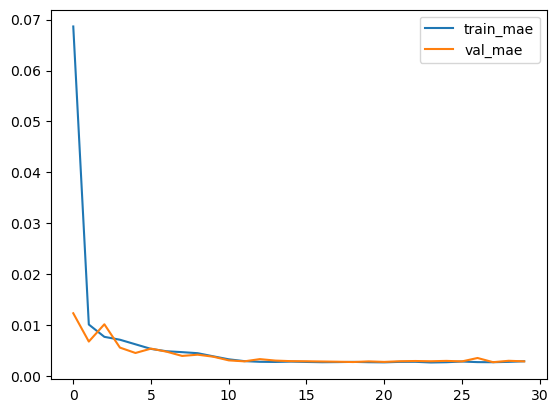



0

In [123]:
# Plot the training and validation loss and MAE
#plt.plot(history.history['loss'][:], label='train_loss')
#plt.plot(history.history['val_loss'][:], label='val_loss')
plt.plot(history.history['mae'], label='train_mae')
plt.plot(history.history['val_mae'], label='val_mae')
plt.legend()
plt.show()
os.system("printf '\a'") # or '\7'

In [ ]:
Epoch 10/10
18/18 [==============================] - 146s 8s/step - loss: 1.8419e-04 - mae: 0.0107 - val_loss: 8.4897e-05 - val_mae: 0.0076

Epoch 3/10 - tf.keras.layers.MultiHeadAttention(num_heads=2, key_dim=4)(x, x, x)
144/144 [==============================] - 24s 165ms/step - loss: 8.0584e-04 - mae: 0.0217 - val_loss: 3.0579e-05 - val_mae: 0.0041

Epoch 18/10 - tf.keras.layers.MultiHeadAttention(num_heads=2, key_dim=4)(x, x, x) (No multiheadattention dropout)
144/144 [==============================] - 33s 233ms/step - loss: 3.2141e-05 - mae: 0.0039 - val_loss: 1.5543e-05 - val_mae: 0.0025

Epoch 5/30
144/144 [==============================] - 33s 230ms/step - loss: 2.5526e-04 - mae: 0.0129 - val_loss: 2.5898e-05 - val_mae: 0.0039

Epoch 11/30 - tf.keras.layers.MultiHeadAttention(num_heads=24, key_dim=64)(x, x, x) (No multiheadattention dropout)
144/144 [==============================] - 79s 546ms/step - loss: 4.5514e-05 - mae: 0.0047 - val_loss: 1.5869e-05 - val_mae: 0.0026


Epoch 21/30 - tf.keras.layers.MultiHeadAttention(num_heads=4, key_dim=64)(x, x, x) - batchnorm after inputs
144/144 [==============================] - 38s 262ms/step - loss: 2.1482e-05 - mae: 0.0028 - val_loss: 1.6468e-05 - val_mae: 0.0024

Epoch 18/30 - same as above but both LSTMs are 32
140/140 [==============================] - 83s 593ms/step - loss: 2.0085e-05 - mae: 0.0028 - val_loss: 1.9584e-05 - val_mae: 0.0028

In [ ]:
test_generator = data_generator(df_dropped, window_size, batch_size, test_indices)
test_steps = len(test_indices) // batch_size
# Generate predictions for the test set
predictions = model.predict(test_generator, steps=test_steps)
test_generator = data_generator(df_dropped, window_size, batch_size, test_indices)
model.evaluate(test_generator, steps=test_steps)

#dates = df.iloc[test_indices].index.strftime("%Y-%m-%d")[:576]

# Extract the predicted high and low values
predicted_high = predictions[:, 0]
predicted_low = predictions[:, 1]

# Reset the test data generator to get actual values
test_generator = data_generator(df_dropped, window_size, batch_size, test_indices, test=True)

# Get the actual high and low values
actual_high = []
actual_low = []
dates = []
open_prices = []
for i in range(test_steps):
    _, batch_targets, op, d = next(test_generator)
    actual_high.extend(batch_targets[:, 0])
    actual_low.extend(batch_targets[:, 1])
    dates.extend(d)
    open_prices.extend(op)
    
    
actual_high = np.exp(actual_high) * open_prices
actual_low = np.exp(actual_low) * open_prices
predicted_high = np.exp(predicted_high) * open_prices
predicted_low = np.exp(predicted_low) * open_prices

# Print the individual predictions with actual values
for i in range(len(predicted_high)):
    print(f"Sample {i+1} - {dates[i]} - Predicted/Actual High: {predicted_high[i]:.2f}, {actual_high[i]:.2f} Predicted/Actual Low: {predicted_low[i]:.2f}, {actual_low[i]:.2f}")


In [ ]:
import shap

background_indices = np.random.choice(train_indices, size=200)
background_data = data_generator(df_dropped, window_size, batch_size, background_indices)
x_background = []
y_background = []
for i in range(len(background_indices)):
    x, y = next(background_data)
    x_background.append(x)
    y_background.append(y)    
x_background = np.concatenate(x_background)

shap_test_indices = np.random.choice(test_indices, size=10)
shap_test_data = data_generator(df_dropped, window_size, batch_size, shap_test_indices)
x_test = []
y_test = []
for i in range(len(shap_test_indices)):
    x, y = next(shap_test_data)
    x_test.append(tf.convert_to_tensor(x))
    y_test.append(y)